In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, division
import os
import torch
#import pandas as pd
#from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import numpy as np
import librosa
import os
from os import listdir
from os.path import isfile,join
import re
import pickle


%aimport read_audio
%aimport dataset
%aimport melLM
%aimport train_attn
#%aimport main_mel_seq2seq


from read_audio import read_pickles

from dataset import Mel
from dataset import MelDataset
from dataset import make_grouping


#from melLM import Encoder
from melLM import EncoderCell
from melLM import BahdanauAttnDecoderRNN
#from melLM import NoAttnDecoder
from melLM import Attn
from melLM import Conv_FB_Highway
#from main_mel_seq2seq import main
%aimport melLM
from melLM import get_encoder
from melLM import get_decoder


from melLM import get_conv_fb_highway 


#from train import train
from train_attn import run_trainer

In [3]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



In [4]:
class Params:
    def __init__(self):
        self.input_size = 80
        self.num_layers = 2
        self.stack_size = 2
        self.r = 1
        self.hidden_size = 600
        self.batch_size = 40
        self.seq_len_max = 100
        self.num_epochs = 551
        self.lr = 0.5*1e-4
        self.restart_file='15'
        self.encoder_type='plain'
        self.dump_mels = True
        


In [5]:

#from main_mel_seq2seq import get_encoder, get_decoder

In [6]:
params = Params()

In [7]:
def normalize_mel(source,target):
    import librosa
    for i in range(len(source)):
        source[i] = librosa.util.normalize(source[i],axis=1)
        target[i] = librosa.util.normalize(target[i],axis=1)


        
    return source,target

In [8]:
def get_normalized_mel(source, target):
    import numpy as np
    
    epsilon = 1e-4
    
    sum_source_vector = np.zeros((params.input_size))
    sum_target_vector = np.zeros((params.input_size))
    
    print('source[0].shape', source[0].shape)
    
    for i in range(len(source)):
        sum_source_vector += np.mean(source[i], axis = 1)
        sum_target_vector += np.mean(target[i], axis = 1)
        
        
    print('yes yes yes yes')
    sum_source_vector /=len(source)
    sum_target_vector /=len(source)

        
    sum_source_vector = np.expand_dims(sum_source_vector, axis=1)
    sum_target_vector = np.expand_dims(sum_target_vector, axis=1)
    #print('ssv.shape', sum_source_vector.shape)
    #print('stv.shape', sum_target_vector.shape)
    
    #print('sum_source_vector', sum_source_vector)
    
        
    for i in range(len(source)):
        source[i] = (source[i] - sum_source_vector)/(sum_source_vector + epsilon)
        target[i] = (target[i] - sum_target_vector)/(sum_target_vector + epsilon)
     
    
    return source, target, sum_source_vector, sum_target_vector

In [9]:
from torch.autograd import Variable
#dir = '/mnt/large_hd/cmu_data'
#dir = '/mnt/raid/cmu_arctic_data'
#dir = '/mnt/raid/combined_data'
#dir = '/mnt/raid/LJSpeech_mels'
#dir = '/mnt/large_hd/audio_mels'
#dir = '/mnt/raid/vcc_mels'
#dir = '/mnt/large_hd/audio_mels'

#dir = '/mnt/large_hd/LJSpeech-256-dumps'
#dir = '/mnt/raid/working_data/LJSpeech_r9y9_new'
dir = '/mnt/raid/working_data/nancy'
#dir = '/mnt/raid/working_data/cmu_arctic/'
#dir = '/mnt/raid/working_data/LJSpeech_16000'

#source_voices = ['SF1','SF2','SF3','SM1','SM2']
#target_voices = ['TF1','TF2','TM1','TM2','TM3']

source_voices = ['nancy']
target_voices = ['nancy']

#source_voices = ['clb']
#target_voices = ['slt']

#source_voices = ['wavs']
#target_voices = ['wavs']


for i in range(len(source_voices)):
    source = read_pickles(dir,source_voices[i]) #dict 
    print('name', source['name'])
    
    if i>0:
        sv += source['mels']
    else:
        sv = source['mels']
        

for i in range(len(target_voices)):
    #tv.append(read_pickles(dir,target_voices[i]))
    target = read_pickles(dir, target_voices[i])
    print('name', target['name'])
    
    if i>0:
        tv += target['mels']
    else:
        tv = target['mels']

print('Creating groupings to class mels and associated assets')
#print(sv[0]['name'])
        
#just do SF1, TF1 for now
#SF1 = make_grouping(sv[0]['mels'])
#TF1 = make_grouping(tv[0]['mels'])

#SF1 = sv[0]['mels']
#TF1 = tv[0]['mels']

#for i in range()


train_split = 0.9
test_split = 0.1
num_batches = len(sv)//params.batch_size
#num_batches = 7000//params.batch_size
data_size = params.batch_size*num_batches 
#print('sv.shape', len(sv), params.batch_size,data_size)

print('Creating Dataset')
#print('yes yes')

#SF1,TF1 = normalize_mel(SF1,TF1)

train_size = int(data_size * train_split)

#sv, tv, mean_sv, mean_tv = get_normalized_mel(sv,tv)

mel_dataset_train = MelDataset(sv[:train_size],tv[:train_size],params.stack_size)
maxlen_source = mel_dataset_train.maxlen_source

mel_dataset_test = MelDataset(sv[train_size:data_size],tv[train_size:data_size],params.stack_size,maxlen_source)


#create train loader 
train_loader = DataLoader(mel_dataset_train, batch_size=params.batch_size,shuffle=True,num_workers=1)
test_loader = DataLoader(mel_dataset_test, batch_size=params.batch_size,shuffle=True,num_workers=1)


print('size of train loader', len(train_loader))
print('size of test loader', len(test_loader))

#print('yes yes')

params = Params()

encoder = get_encoder(params)
#encoder = Encoder(params.input_size,params.hidden_size,params.batch_size, params.num_layers)
#decoder = get_decoder(params)

#encoder = EncoderCell(params.input_size,params.hidden_size)
encoder = encoder.cuda()


decoder = get_decoder(params)
decoder = decoder.cuda()





name nancy
name nancy
Creating groupings to class mels and associated assets
Creating Dataset
shape (80, 269)
maxlen_source 269
maxlen src 269
shape (80, 269)
maxlen_source 269
maxlen src 269
size of train loader 272
size of test loader 31
pyramidal GRU
Initializing Pyramidal Encoder 
Initializing Pyramid


/home/pytorch/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Bahdanau Attention Decoder


In [10]:
pwd

'/home/pytorch/projects/dev/vcc_sr_16000_2'

In [11]:
print('encoder', encoder)

encoder Pyramidal_Encoder(
  (pyramid): Pyramidal_GRU(
    (gru0): GRU(80, 300, batch_first=True, dropout=0.1, bidirectional=True)
    (pyramid): ModuleList(
      (0): BiGRU(
        (GRU_f): GRU(1200, 300, dropout=0.1)
        (GRU_b): GRU(1200, 300, dropout=0.1)
      )
      (1): BiGRU(
        (GRU_f): GRU(1200, 300, dropout=0.1)
        (GRU_b): GRU(1200, 300, dropout=0.1)
      )
    )
  )
)


In [12]:
for i, [sample,seq_len] in enumerate(train_loader):
    mask = sample['mask']
    print('mask', mask)

mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  

mask tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  

mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  

mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  

mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  

mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  

mask tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  

mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
mask tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  

In [13]:
print(params.batch_size)

40


In [14]:
def plot_mel(mel):
    import matplotlib.pyplot as plt
    import numpy as np
    import librosa.display 
    plt.figure(figsize=(10, 4))
    #librosa.display.specshow(librosa.power_to_db(mel,ref=np.max),
    #                 y_axis='mel', fmax=8000, x_axis='time')
    librosa.display.specshow(mel,
                     y_axis='mel', fmax=8000, x_axis='time')
    #plt.colorbar(format='%+2.0f dB')
    #plt.title('Mel spectrogram')
    #plt.tight_layout()
    plt.show()
    #plt.savefig('dumps2/mel_'+str(i)+'.png')
    #plt.close()

In [15]:
for i,[sample,seq_len] in enumerate(train_loader):
    src = sample['source']
    tgt = sample['target']
    mask = sample['mask']
    print('src.shape',src[0].shape)
    #plot_mel(src[0].numpy())
    #plot_mel(tgt[0].numpy())
    break
    


src.shape torch.Size([80, 276])


In [16]:
s = src[0].numpy()
import matplotlib.pyplot as plt
import numpy as np
import librosa.display 
plt.figure()
'''librosa.display.specshow(librosa.power_to_db(s,ref=np.max),
                     y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()
plt.savefig('dumps2/mel_'+str(i)+'.png')
plt.close()'''

"librosa.display.specshow(librosa.power_to_db(s,ref=np.max),\n                     y_axis='mel', fmax=8000, x_axis='time')\nplt.colorbar(format='%+2.0f dB')\nplt.title('Mel spectrogram')\nplt.tight_layout()\nplt.show()\nplt.savefig('dumps2/mel_'+str(i)+'.png')\nplt.close()"

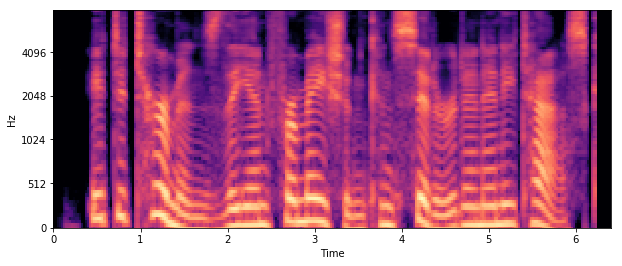

sv[0] [[0.         0.         0.         ... 0.01761331 0.07638495 0.1276155 ]
 [0.         0.         0.         ... 0.09932292 0.1561169  0.20841618]
 [0.         0.         0.         ... 0.20004907 0.20856929 0.22910833]
 ...
 [0.         0.         0.         ... 0.4813494  0.4455599  0.3865934 ]
 [0.         0.         0.         ... 0.42576697 0.40356442 0.34873205]
 [0.         0.         0.         ... 0.40519845 0.37153223 0.31261942]]


In [17]:
import audio
s = src[0].numpy()

plot_mel(s)
#print('mean_sv', mean_sv)
print('sv[0]', sv[0])

In [18]:
seq_len = src[0].shape[1]
print(seq_len)

276


In [19]:
#seq_len = 208
conv_fb_highway = get_conv_fb_highway(params,seq_len)
conv_fb_highway = conv_fb_highway.cuda()

In [20]:
encoder_optimizer = optim.Adam(encoder.parameters(),params.lr)
decoder_optimizer = optim.Adam(decoder.parameters(), params.lr)
conv_fb_highway_optimizer = optim.Adam(conv_fb_highway.parameters(),params.lr)

loading encoder, decoder, conv_fb_highway
epoch 0
schedule 1.0


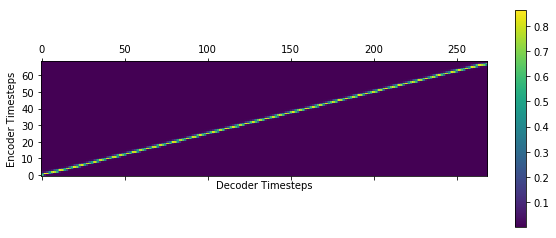

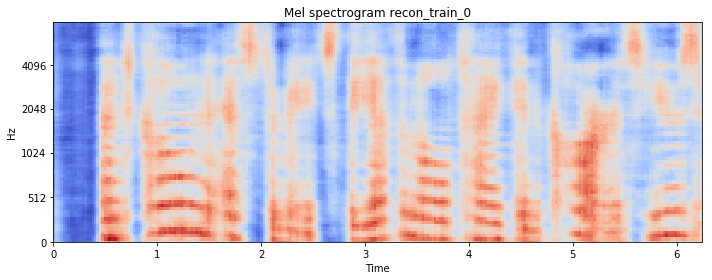

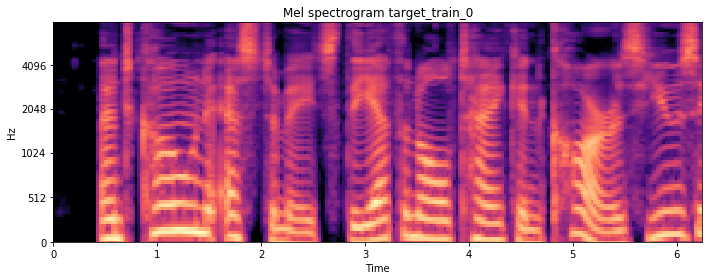

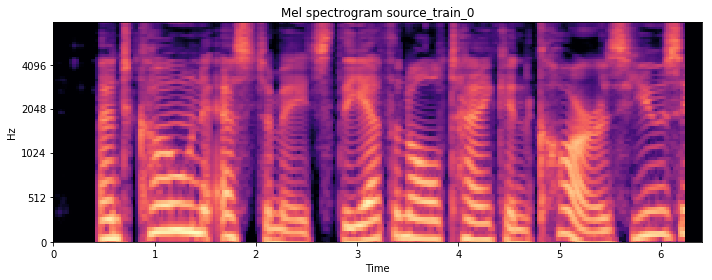

train_loss 11053040.51953125
src.size() torch.Size([40, 80, 276])


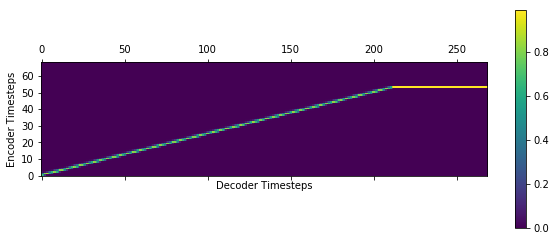

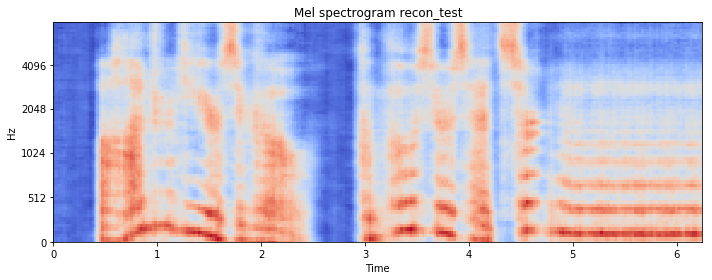

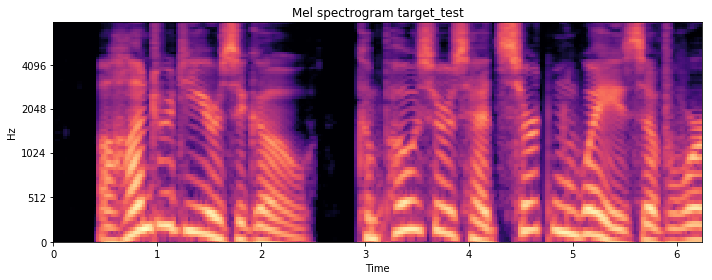

t.shape (80, 276)


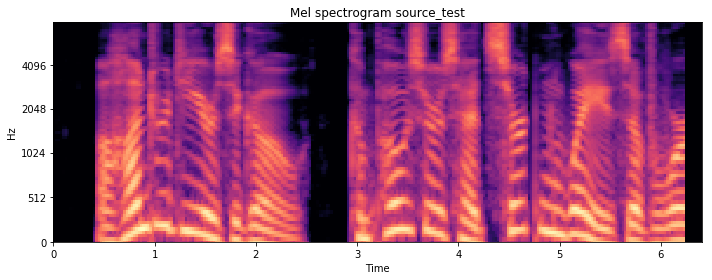

s.size() torch.Size([80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.siz

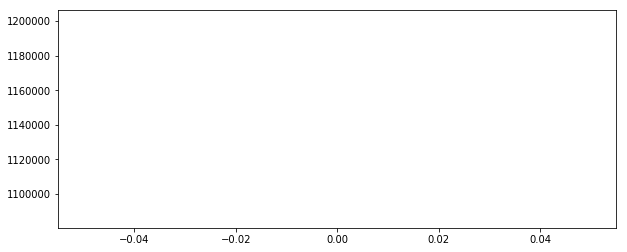

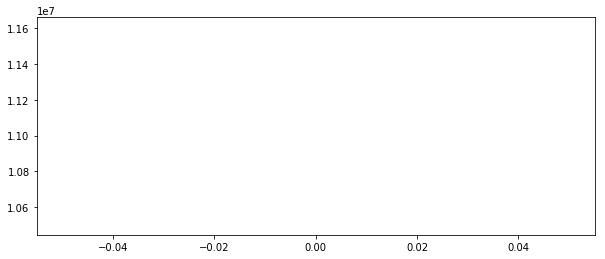

saving logs for epoch  0
epoch 1
schedule 1.0


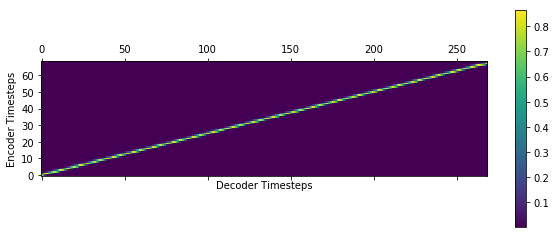

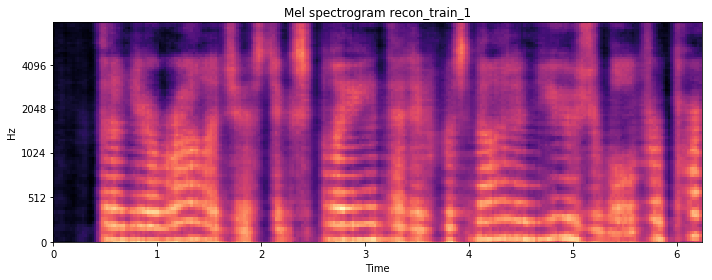

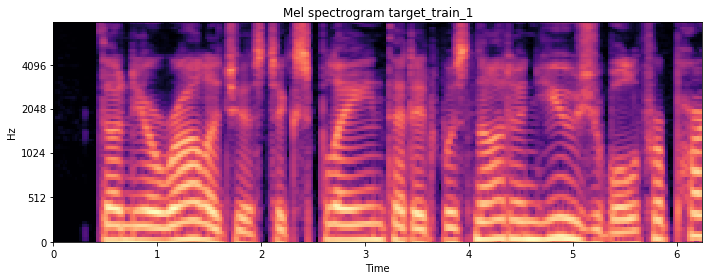

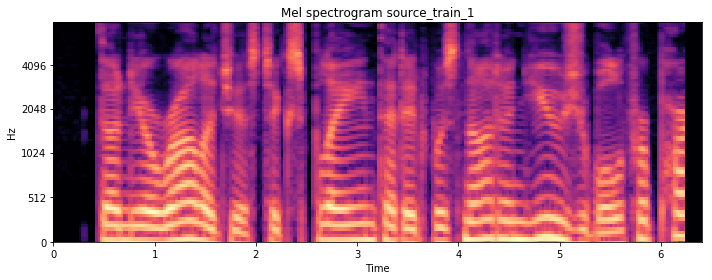

train_loss 10210622.95703125
src.size() torch.Size([40, 80, 276])


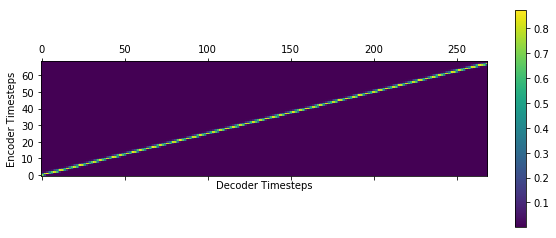

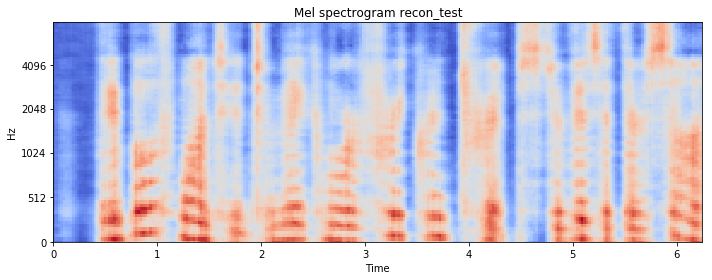

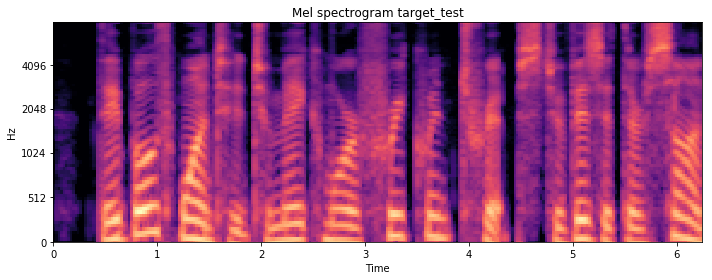

t.shape (80, 276)


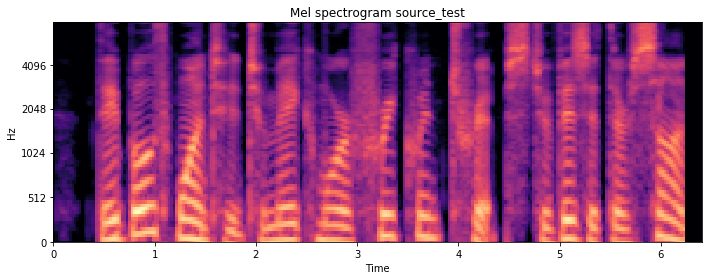

s.size() torch.Size([80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.siz

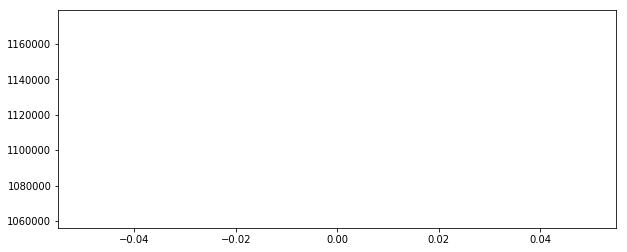

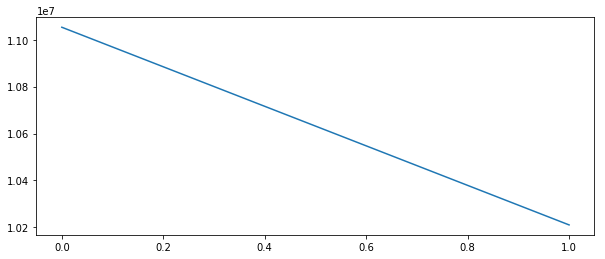

epoch 2
schedule 1.0


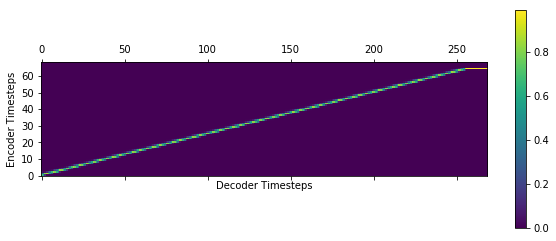

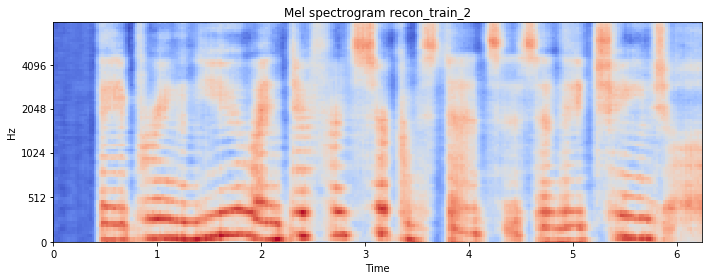

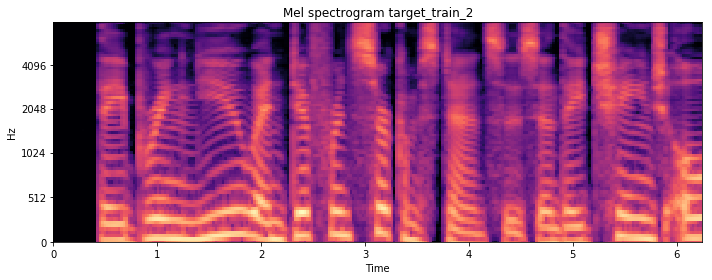

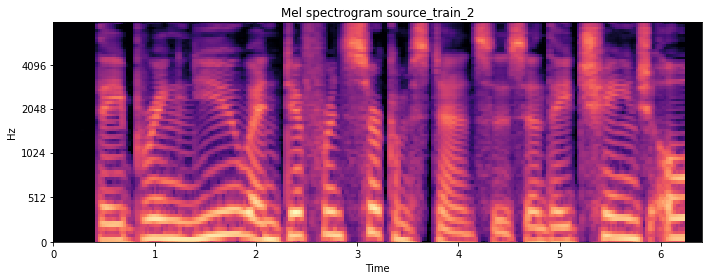

train_loss 9871450.91015625
src.size() torch.Size([40, 80, 276])


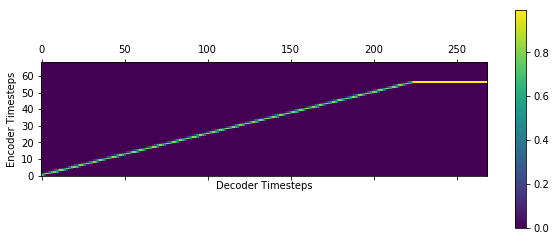

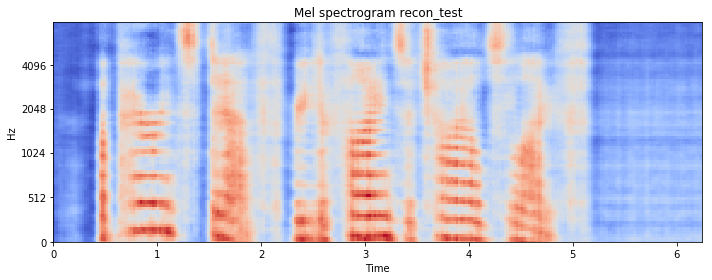

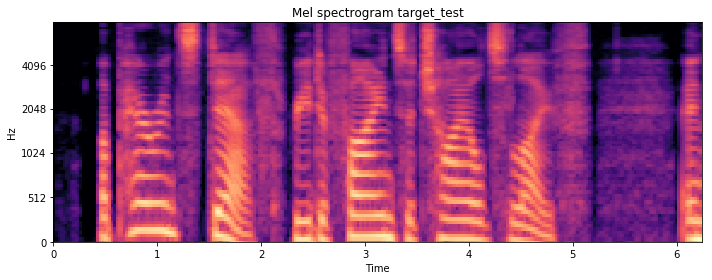

t.shape (80, 276)


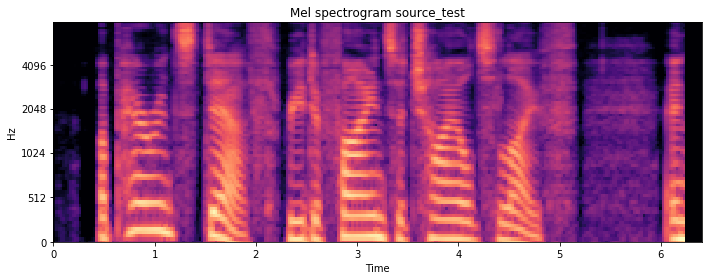

s.size() torch.Size([80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.siz

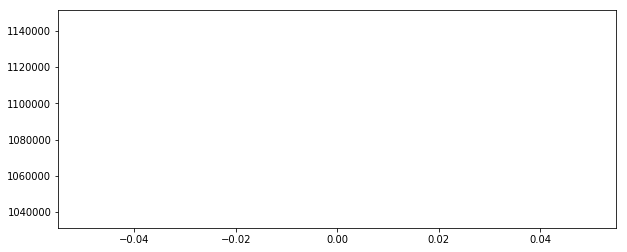

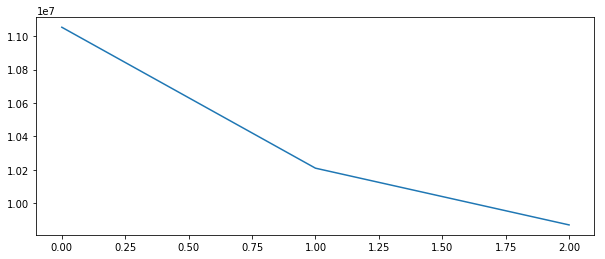

epoch 3
schedule 1.0


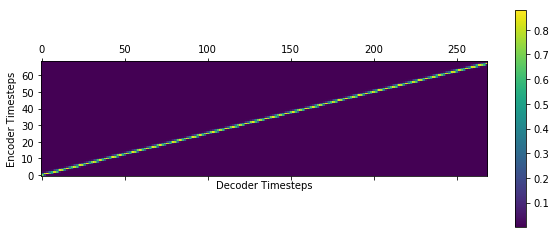

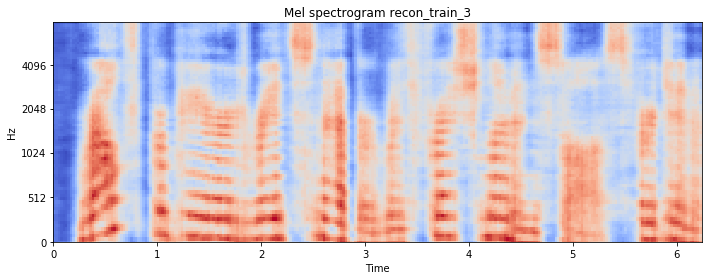

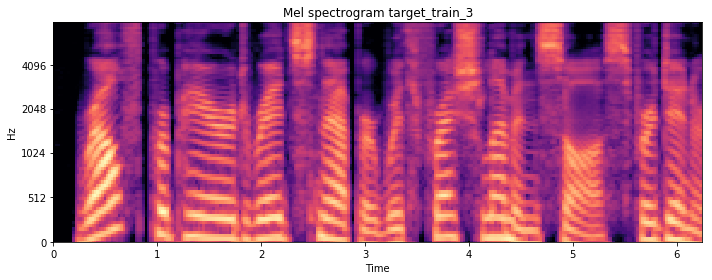

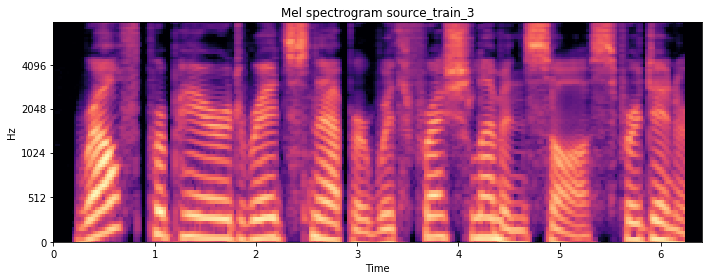

train_loss 9634662.60546875
src.size() torch.Size([40, 80, 276])


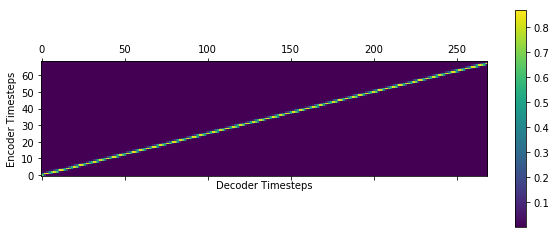

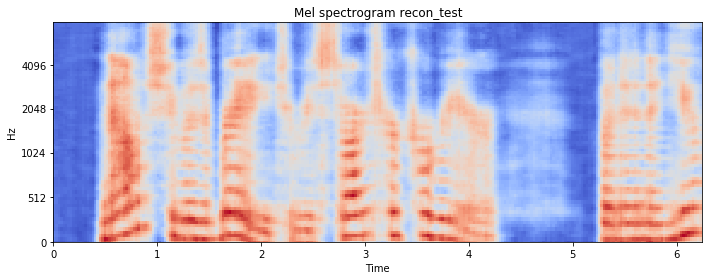

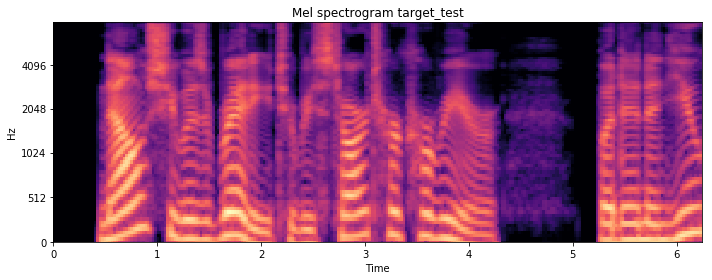

t.shape (80, 276)


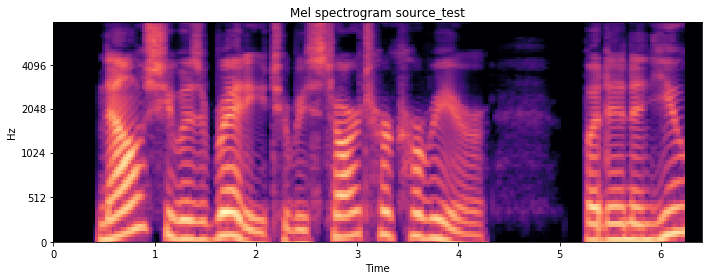

s.size() torch.Size([80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.siz

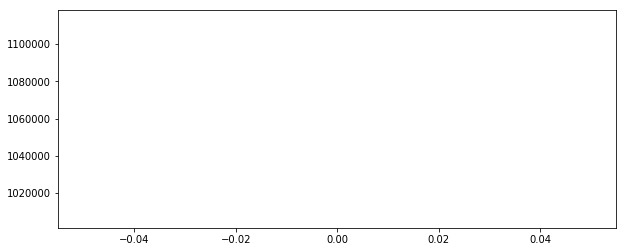

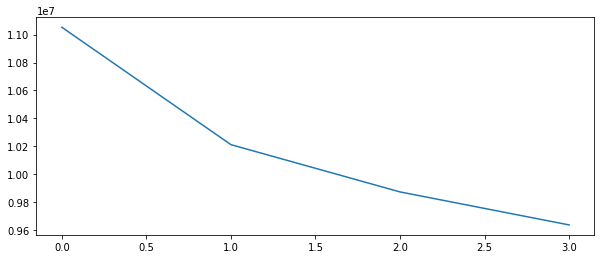

epoch 4
schedule 1.0


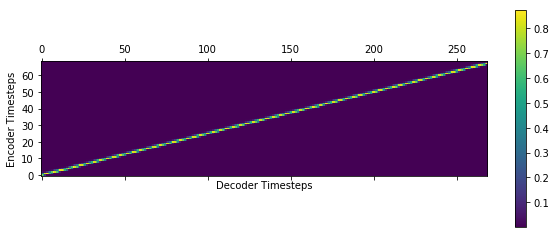

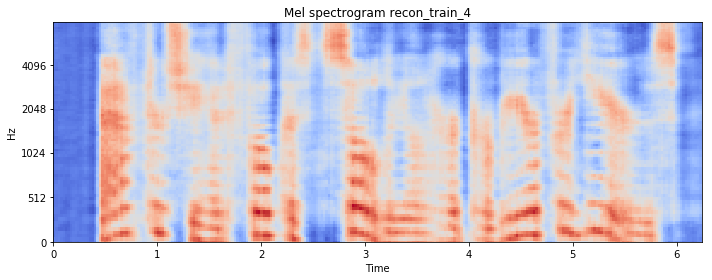

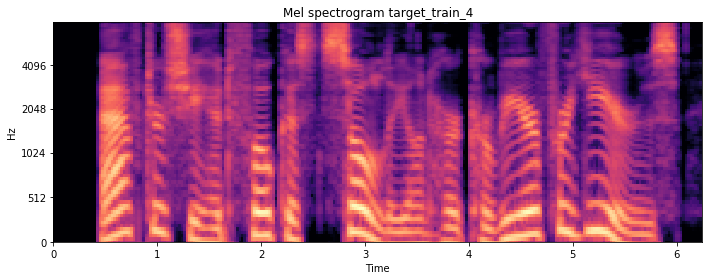

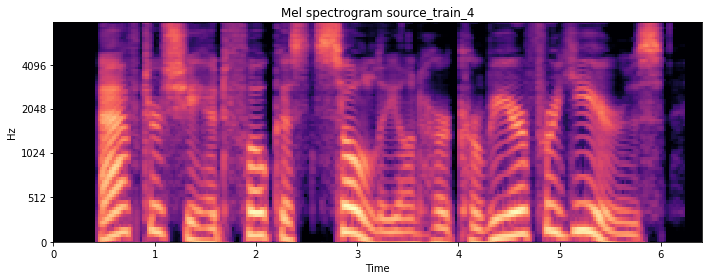

train_loss 9381167.009765625
src.size() torch.Size([40, 80, 276])


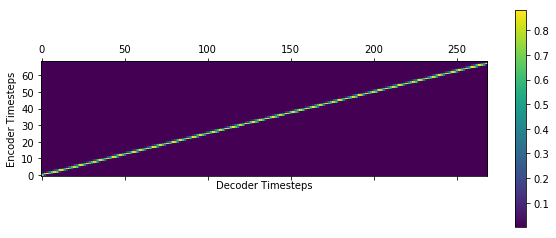

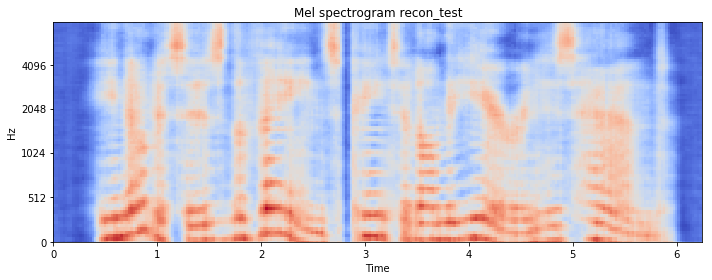

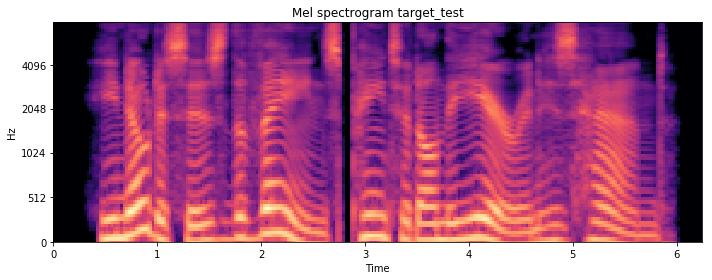

t.shape (80, 276)


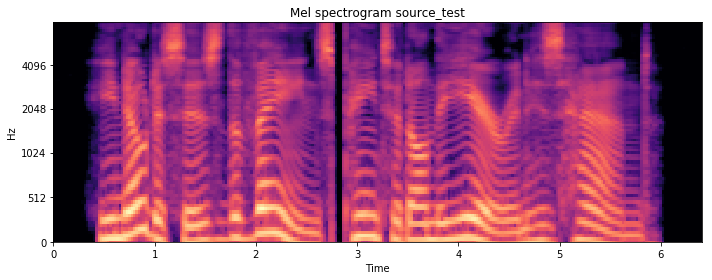

s.size() torch.Size([80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.siz

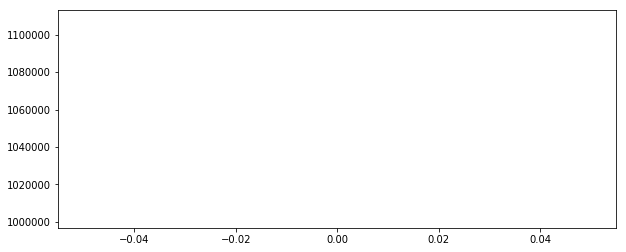

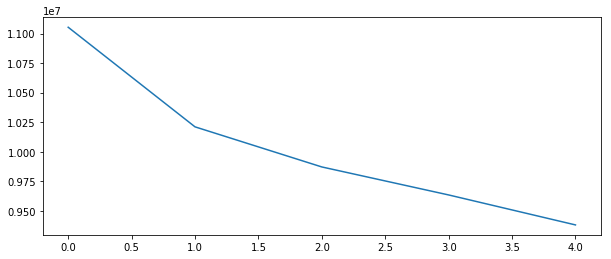

epoch 5
schedule 1.0


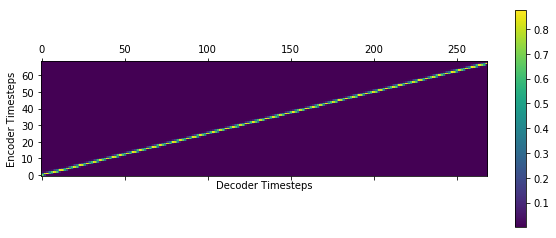

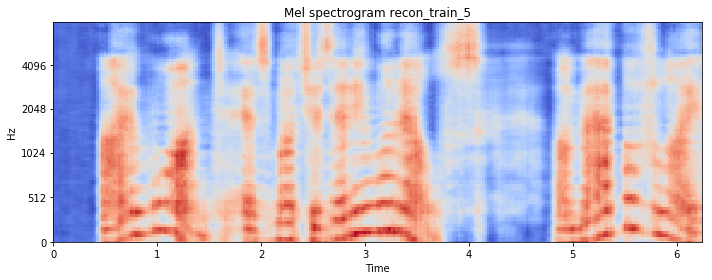

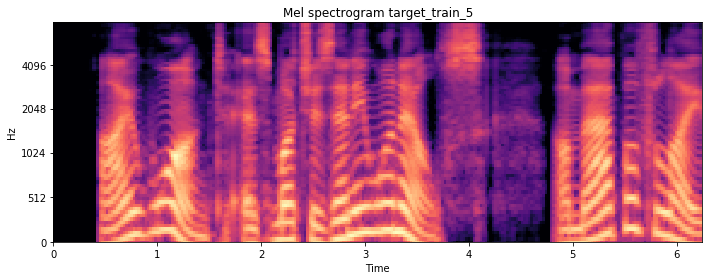

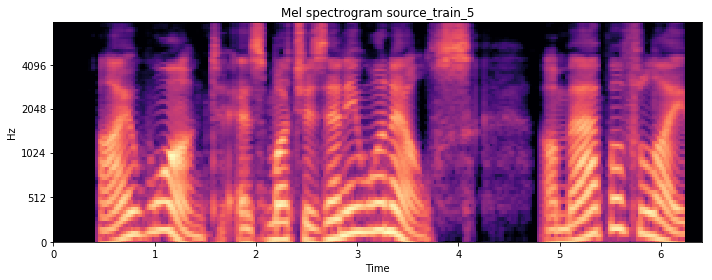

train_loss 9288298.3203125
src.size() torch.Size([40, 80, 276])


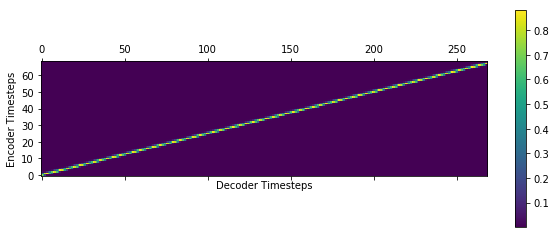

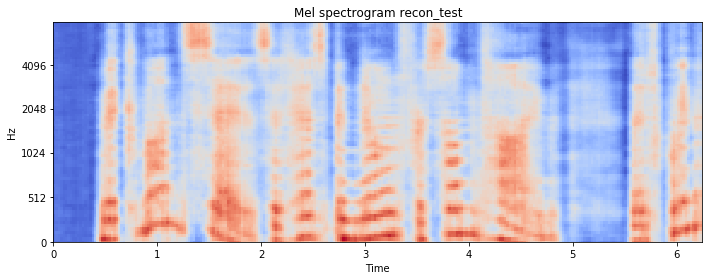

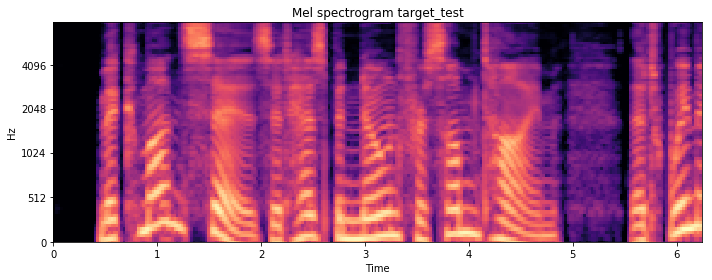

t.shape (80, 276)


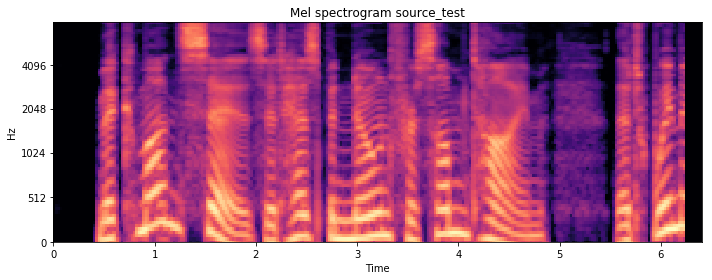

s.size() torch.Size([80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.size() torch.Size([40, 80, 276])
src.siz

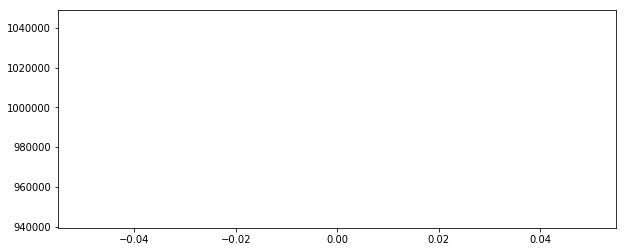

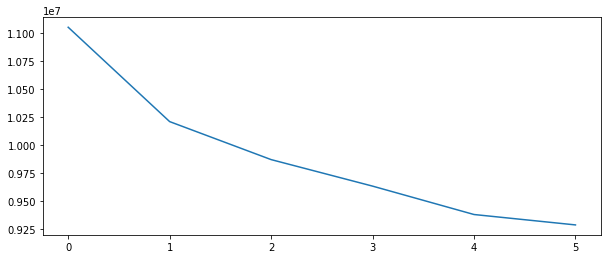

saving logs for epoch  5
epoch 6
schedule 1.0


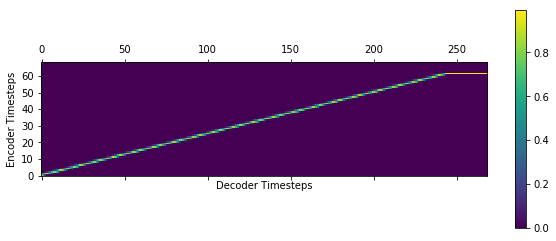

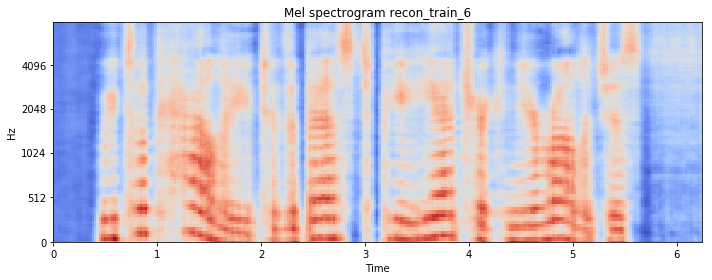

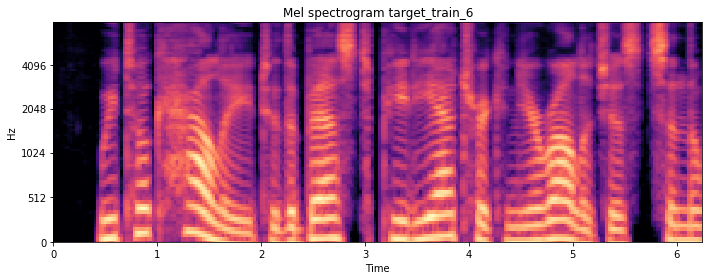

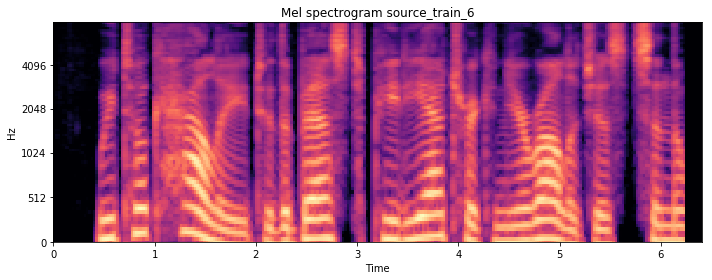

KeyboardInterrupt: 

In [21]:
run_trainer(train_loader, test_loader,params, encoder,decoder,conv_fb_highway,encoder_optimizer,decoder_optimizer,conv_fb_highway_optimizer)

In [ ]:
80*208*4

In [ ]:

from test_attn import run_tester
from test_attn import test

In [ ]:
run_tester(test_loader,params,encoder,decoder,conv_fb_highway)

In [ ]:
190*600

In [ ]:
a = torch.ones(10,10)
b = torch.zeros(10)

In [ ]:
b = b.expand_as(a)

In [ ]:
b.shape

In [ ]:
c = torch.cat((a,b),1)

In [ ]:
c.size()

In [ ]:
a = torch.ones(10,300)

In [ ]:
a = a.expand(16,10,300)

In [ ]:
x = torch.ones(2,5)
y1 = torch.ones(2)
y2 = torch.zeros(3)

In [ ]:
y = torch.cat((y1,y2),0)

In [ ]:
y.size()

In [ ]:
y = y.unsqueeze(0)

In [ ]:
z = x*y

In [ ]:
z

In [ ]:
m = torch.zeros(10,20)

In [ ]:
x = torch.ones(10,20,80)

In [ ]:
m = m.unsqueeze(2)

In [ ]:
m+x

In [ ]:
in_dim = [80,256]

In [ ]:
sizes = [256,128]

In [ ]:
print(sizes[:-1])

In [ ]:
in_dim + sizes[:-1]

In [ ]:
sizes[1:]

In [ ]:
[in_dim]+sizes[:-1]

In [ ]:
in_dim = 128

In [ ]:
[in_dim]+sizes[:-1]

In [ ]:
mask = torch.ByteTensor(4,4).zero_().byte()

In [ ]:
mask[0][:2] = 1

In [ ]:
print(mask)

In [ ]:
v = 4*torch.ones(4,4)

In [ ]:
v.masked_fill_(mask,-50)

In [ ]:
attn = [ 0.2081,  0.4601,  0.7598,  0.9615,  0.1249, -1.3553, -2.1334,
        -2.0015, -1.3928, -0.6678, -0.0965,  0.2664,  0.6829,  1.1478,
         1.2630,  1.2874,  1.2073]

In [ ]:
import numpy as np

In [ ]:
attn = np.asarray(attn)

In [ ]:
attn = torch.from_numpy(attn)

In [ ]:
attn

In [ ]:
mask = [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
         1,  1,  1]

In [ ]:
mask = np.asarray(mask)

In [ ]:
mask = torch.from_numpy(mask)

In [ ]:
mask

In [ ]:
mask = mask.byte()

In [ ]:
attn.masked_fill(mask,-10)

In [ ]:
attn = Variable(attn)

In [ ]:
attn.data.masked_fill(mask,-10)

In [ ]:
attn

In [ ]:
attn = Variable(attn.data.masked_fill(mask,-10))

In [ ]:
attn

In [ ]:
import torch

In [ ]:
import torch.nn as nn

In [ ]:
x = torch.FloatTensor(10,5,1)
y = torch.FloatTensor(10,5,6)

In [ ]:
z = x+y

In [ ]:
print(z.size())

In [ ]:
import numpy as np

In [ ]:
x = np.ones((80,20))
y = np.zeros((80))

In [ ]:
y += np.sum(x, axis=1)

In [ ]:
y.shape

In [ ]:
x = np.ones(4)

In [ ]:
x.shape

In [ ]:
y = np.expand_dims(x, axis=1)

In [ ]:
y.shape

In [ ]:
z = np.ones((4,20))

In [ ]:
q = np.ones((4,1))

In [ ]:
z-q

In [ ]:
import os
print(os.getcwd())

In [ ]:
x=[1]
y=[2]

In [ ]:
x+y